# Setup

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
using Logging
import CairoMakie as cm
cm.activate!(type = "png")
using Makie.Colors
using Makie.GeometryBasics
using Makie

using DifferentialEquations
using MiniLoggers
using ProgressMeter
using LoggingExtras
using Revise
using Dates
using YAXArrays
using DimensionalData

import Optim as OP

using LinearAlgebra
import LsqFit as LF

import Peaks
using Zygote

using JSON3

  Activating project at `~/.julia/environments/SCC`


In [2]:
import SuperconductingCavities as SC

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /Users/gavinrockwood/.julia/packages/YAXArrayBase/M48vP/ext/NetCDFExt.jl:110


## Logging Setup

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

## Some Universal Formatting Stuff

In [4]:
greens = [colorant"#1B5E20", colorant"#388E3C", colorant"#66BB6A", colorant"#C8E6C9"] # Green
oranges = [colorant"#FFA000", colorant"#FFC107", colorant"#FFCC80", colorant"#FFECB3"] # Orange 
#oranges = [colorant"#F9A825", colorant"#FDD835", colorant"#FFEE58", colorant"#FFF9C4"] # Orange 
#colors2 = [colorant"#FF6F00", colorant"#FFA000", colorant"#FFEB3B", colorant"#FFE082"] # Orange
blues = [colorant"#1565C0", colorant"#2196F3", colorant"#90CAF9", colorant"#BBDEFB"] # Blue
#reds = [colorant"#880E4F", colorant"#D81B60", colorant"#F06292", colorant"#F8BBD0"] # Red
reds = [colorant"#C62828", colorant"#F44336", colorant"#EF9A9A", colorant"#FFCDD2"] # Red
purples = [colorant"#7B1FA2", colorant"#AB47BC", colorant"#CE93D8", colorant"#E1BEE7"] # Purple
#purples = [colorant"#AD1457", colorant"#D81B60", colorant"#F06292", colorant"#F8BBD0"] # Purple

colors = hcat(greens, oranges, blues, reds, purples)

# Single Mode State Evolution Plots

## Mode 3

In [5]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

### f0g1 Sidebands

#### Sub Stroboscopic Sampling Plot

##### Getting Data

In [211]:
spns = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"])*52
ψi = Mode3.dressed_states[(2,0)]
run_res_sss = SC.Dynamics.RunPulseSequence(Mode3, ψi, ["sb_f0g1"], spns = spns)


The Name for this run is: Operator_Sequence_Thu-Dec-19-24.13.29
It is being saved at: Data/
[2024-12-19 13:29:21] Info: Running operator sb_f0g1
[2024-12-19 13:29:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-12-19 13:29:27] Info: Time Evolution Complete
[2024-12-19 13:29:27] Info: Saving Steps
[2024-12-19 13:29:30] Info: Done with Step_1
[2024-12-19 13:29:30] Info: Done With Running Sequence
[2024-12-19 13:29:30] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.00678965, 0.0135793, 0.0203689, 0.0271586, 0.0339482, …
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [7]:
EVs_sss = SC.Utils.Get_EVs(run_res_sss["states"], SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

##### Plotting

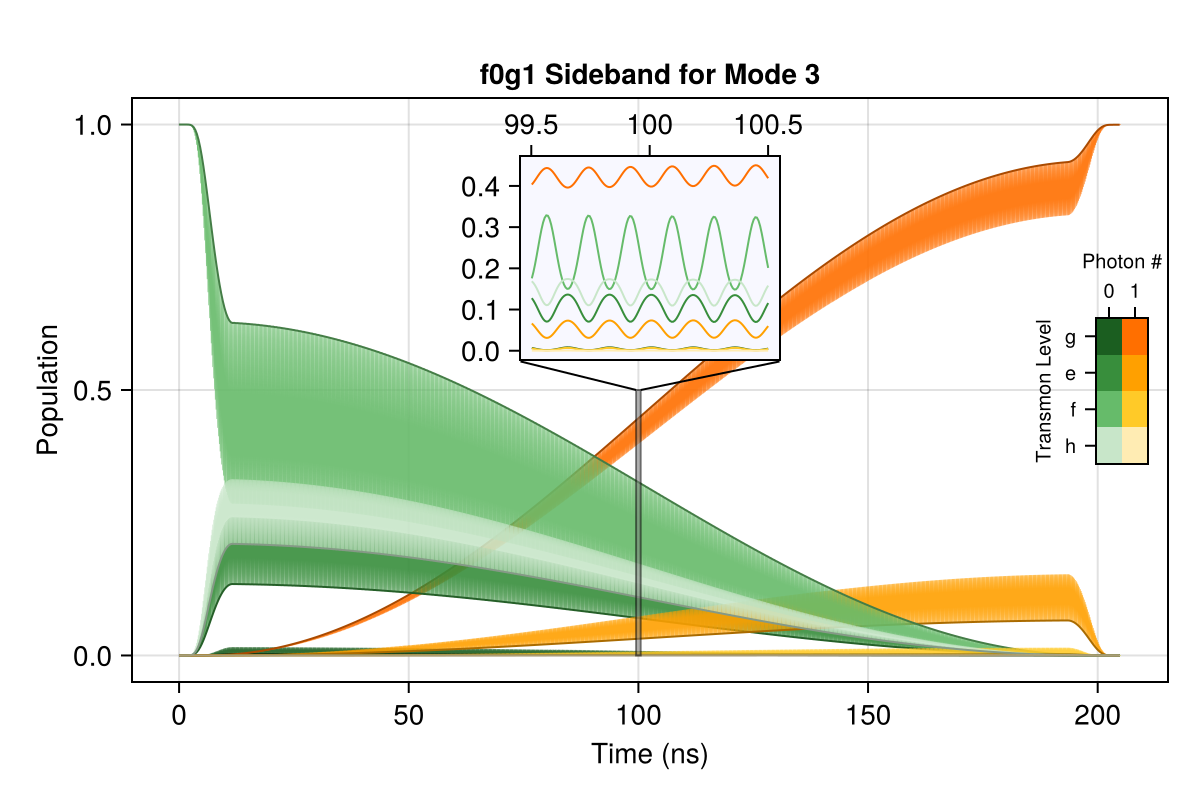

CairoMakie.Screen{IMAGE}


In [464]:
run_res = run_res_sss
EVs = EVs_sss

figsize = (600, 400)
fig = cm.Figure(size = figsize, px_per_unit = 10)

tlevels = [0,1,2,3]
clevels = [0,1]

main_ax = cm.Axis(fig[1,1], title = "f0g1 Sideband for Mode 3", xlabel = "Time (ns)", ylabel = "Population")

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color, linewidth = 0.25, alpha = 0.9)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    x = run_res["times"][1:52:end]
    y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color/1.5, linewidth = 1, alpha = 1)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
    
end
#cm.Legend(fig[1,2], main_ax, nbanks = 1)
#cm.axislegend(main_ax, position = :rc, nbanks = 2)

w_rel = 0.25
h_rel = 0.35
inset_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.5,
                    valign = 0.85,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([99.5,100,100.5], ["99.5", "100", "100.5"]))
                    
#cm.hidedecorations!(inset_ax)
cm.translate!(inset_ax.scene, 0, 0, 5)
cm.translate!(inset_ax.elements[:background], 0, 0, 5)

start_time = 99.5
stop_time = 100.5

start = findfirst(x -> x > start_time, run_res["times"])
stop = findfirst(x -> x > stop_time, run_res["times"])

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][start:stop]
    y = real.(EVs[(pair[2],pair[1])])[start:stop]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(inset_ax, x,y, color = color, linewidth = 1, alpha = 1, label = label)
end

cm.poly!(main_ax, Point2f[(start_time, 0), (stop_time, 0), (stop_time, 0.5), (start_time, 0.5)], color = (:grey, 0.5), strokecolor = (:black, 0.5), strokewidth = 1)

x0 = start_time
y0 = 0.5

xf = w_rel*run_res["times"][end]*1.45
yf = (0.5*h_rel/4+0.51)

cm.lines!(main_ax, [x0, xf], [y0, yf], color = :black, linewidth = 1)

x0 = stop_time
y0 = 0.5
xf = run_res["times"][end] - (w_rel*run_res["times"][end]*1.45)
yf = (0.5*h_rel/4+0.51)

cm.lines!(main_ax, [x0, xf], [y0, yf], color = :black, linewidth = 1)


w_rel = 0.05
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.98,
                    valign = 0.5,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([1,2], ["0", "1"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:2, end:-1:1]
cm.heatmap!(legend_ax, z)




cm.save("figures/f0g1SidebandSubStrobSampling.png", fig, px_per_unit = 10)
display(fig)

#### Calibrated f0g1 Sideband

##### Getting Data

In [628]:
ψ1 = Mode3.dressed_states[(2,0)]
spns = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"])*52
run_res_ramp = SC.Dynamics.RunSingleOperator(Mode3, ψ1, Mode3.Stuff["op_drive_params"]["sb_f0g1"], spns = spns)

[2024-12-20 15:23:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-12-20 15:24:03] Info: Time Evolution Complete
[2024-12-20 15:24:03] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 30202
num_expect = 0
ODE alg.: Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [629]:
EVs_ramp = SC.Utils.Get_EVs(run_res_ramp.states, SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

In [631]:
floq_tracking_ramp = SC.Dynamics.Get_Pulse_Floquet_Sweep(Mode3.hilbertspace, Mode3.Ô_drive, Mode3.Stuff["op_drive_params"]["sb_f0g1"]);

[2024-12-20 15:25:00] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


[2024-12-20 15:26:17] Info: Done With Floquet Sweep
[2024-12-20 15:26:17] Info: Tracking State


Progress:  17%|███████                                  |  ETA: 0:00:06

[2024-12-20 15:26:18] Info: Running the necessary time evolutions


In [632]:
floq_projections_ramp = SC.Dynamics.Pulse_Floquet_Projections(run_res_ramp.states[1:52:end], floq_tracking_ramp);


##### Plot

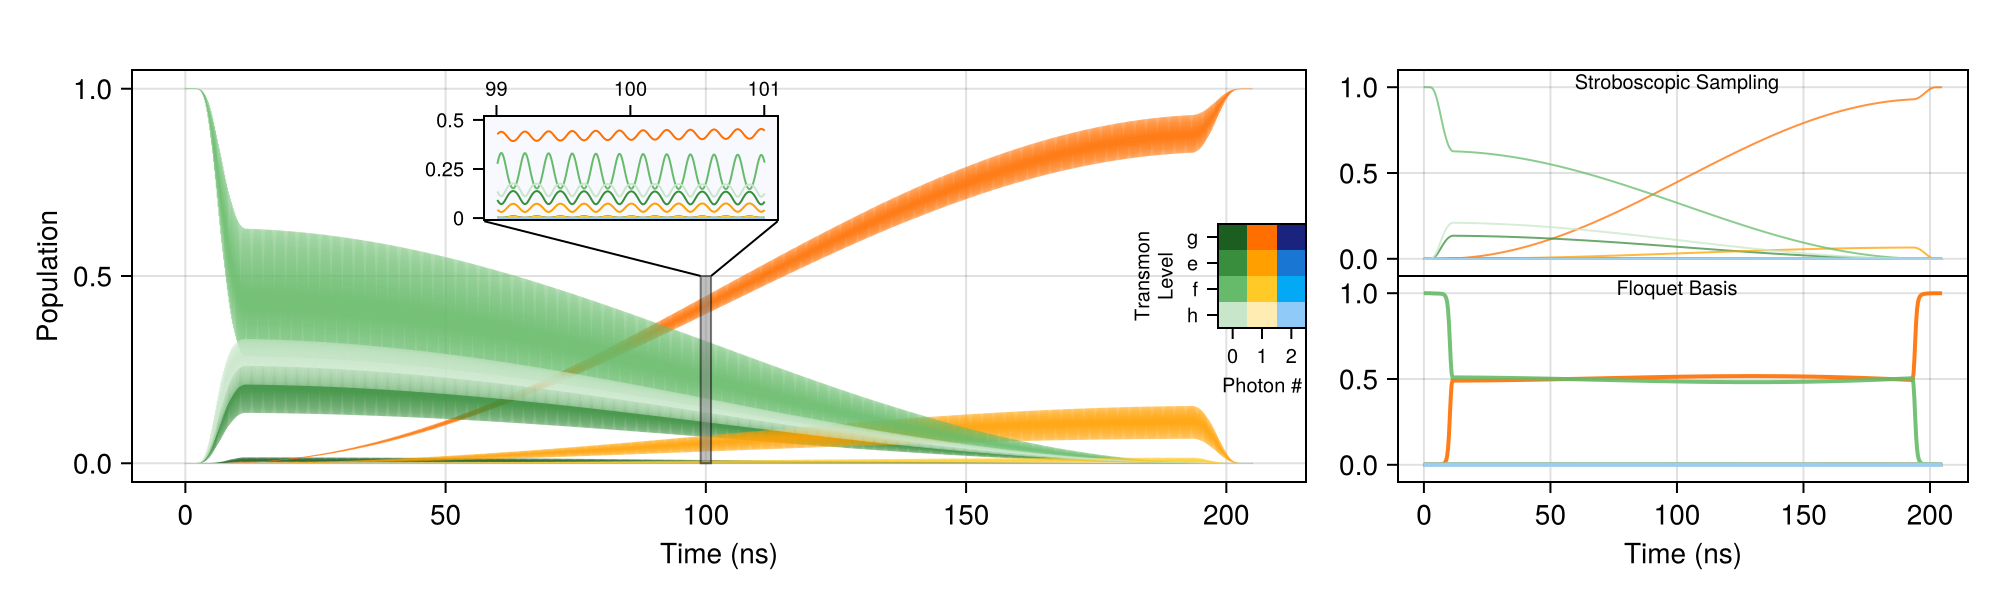

CairoMakie.Screen{IMAGE}


In [701]:
run_res = Dict{String, Any}("states" => run_res_ramp.states, "times" => run_res_ramp.times)
EVs = EVs_ramp

figsize = (1000, 300)
fig = cm.Figure(size = figsize, px_per_unit = 10)

ga = fig[1,1:2] = cm.GridLayout()
gb = fig[1,3] = cm.GridLayout()

gA = Axis(ga[1, 1], xlabel = "Time (ns)", ylabel = "Population")
gB1 = Axis(gb[1, 1], limits = ((nothing, nothing), (-0.1, 1.1)))
cm.hidexdecorations!(gB1, grid = false)
gB2 = Axis(gb[2, 1], limits = ((nothing, nothing), (-0.1, 1.1)), xlabel = "Time (ns)")
cm.rowgap!(gb, 0)

tlevels = [0,1,2,3]
clevels = [0,1,2]

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(gA, x,y, color = color, linewidth = 0.25, alpha = 0.9)
    
end




w_rel = 0.075
h_rel = 0.25
legend_ax = cm.Axis(ga[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 1,
                    valign = 0.5,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:bottom),
                    xticks = ([1,2,3], ["0", "1", "2"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon\nLevel",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:3, end:-1:1]
cm.heatmap!(legend_ax, z)


for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:52:end]
    y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(gB1, x,y, color = color, linewidth = 1, alpha = 0.75)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    
end


for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:52:end]
    y = real.(floq_projections_ramp[string((pair[2],pair[1]))])#[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(gB2, x,y, color = color, linewidth = 2, alpha = 0.9)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
end
cm.text!(gB2, 100,1.1, text = "Floquet Basis", align = (:center, :top), fontsize = 10)
cm.text!(gB1, 100,1.1, text = "Stroboscopic Sampling", align = (:center, :top), fontsize = 10)

w_rel = 0.25
h_rel = 0.25
inset_ax = cm.Axis(ga[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.4,
                    valign = 0.85,
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([99,100,101], ["99", "100", "101"]),
                    yticks = ([0.0,0.25,0.5], ["0", "0.25", "0.5"]),
                    limits = (nothing, (-0.01,0.52)))
                    
#cm.hidedecorations!(inset_ax)
cm.translate!(inset_ax.scene, 0, 0, 5)
cm.translate!(inset_ax.elements[:background], 0, 0, 5)

start_time = 99
stop_time = 101

start = findfirst(x -> x > start_time, run_res["times"])
stop = findfirst(x -> x > stop_time, run_res["times"])

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][start:stop]
    y = real.(EVs[(pair[2],pair[1])])[start:stop]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(inset_ax, x,y, color = color, linewidth = 1, alpha = 1, label = label)
end

cm.poly!(gA, Point2f[(start_time, 0), (stop_time, 0), (stop_time, 0.5), (start_time, 0.5)], color = (:grey, 0.5), strokecolor = (:black, 0.5), strokewidth = 1)

x0 = start_time
y0 = 0.5

xf = w_rel*run_res["times"][end]*1.12
yf = (0.5*h_rel/4+0.615)

cm.lines!(gA, [x0, xf], [y0, yf], color = :black, linewidth = 1)

x0 = stop_time
y0 = 0.5
xf = run_res["times"][end] - (w_rel*run_res["times"][end]*1.78)
yf = (0.5*h_rel/4+0.615)

cm.lines!(gA, [x0, xf], [y0, yf], color = :black, linewidth = 1)

cm.save("figures/f0g1SidebandRampV2.png", fig, px_per_unit = 10)
display(fig)

#### Calibrated f0g1 Sideband with Short Ramp

##### Getting Data

In [11]:

println(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["Envelope Args"])

Dict{String, Any}("pulse_time" => 205.05411739244443, "k" => 2, "ramp_time" => 11.6257)


In [99]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]

ν = Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]
ε = Mode3.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"]
shift = Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"]

T0 = abs(1/(ν+shift))

t_range = [190, 200]
opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, ν, shift, t_range, "Bump_Ramp",Dict("ramp_time" => 0.5))


[2024-12-25 20:46:46] Info: On Level 1
[2024-12-25 20:46:46] Info: On Step 1: t = 190.0
[2024-12-25 20:46:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-12-25 20:46:51] Info: Time Evolution Complete
[2024-12-25 20:46:51] Info: Done with Level_1_step_1
[2024-12-25 20:46:51] Info: Accurace: 0.7135070584284586
[2024-12-25 20:46:51] Info: ------------------------------------------------------------------------------
[2024-12-25 20:46:51] Info: On Step 2: t = 192.5
[2024-12-25 20:46:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-12-25 20:46:56] Info: Time Evolution Complete
[2024-12-25 20:46:56] Info: Done with Level_1_step_2
[2024-12-25 20:46:56] Info: Accurace: 0.7135916573428395
[2024-12-25 20:46:56] Info: ------------------------------------------------------------------------------
[2024-12-25 20:46:56] Info: O

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 194.844
  "Envelope Args" => Dict("pulse_time"=>194.844, "k"=>2.0, "ramp_time"=>0.5)
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.716326
  "freq_d"        => -2.86996

In [100]:
spns = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"])*52
run_res_no_ramp = SC.Dynamics.RunSingleOperator(Mode3, ψ1, opt_res, spns = spns)

[2024-12-25 20:49:01] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-12-25 20:49:07] Info: Time Evolution Complete
[2024-12-25 20:49:07] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 28698
num_expect = 0
ODE alg.: Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [101]:
EVs_no_ramp = SC.Utils.Get_EVs(run_res_no_ramp.states, SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

##### Making Plot

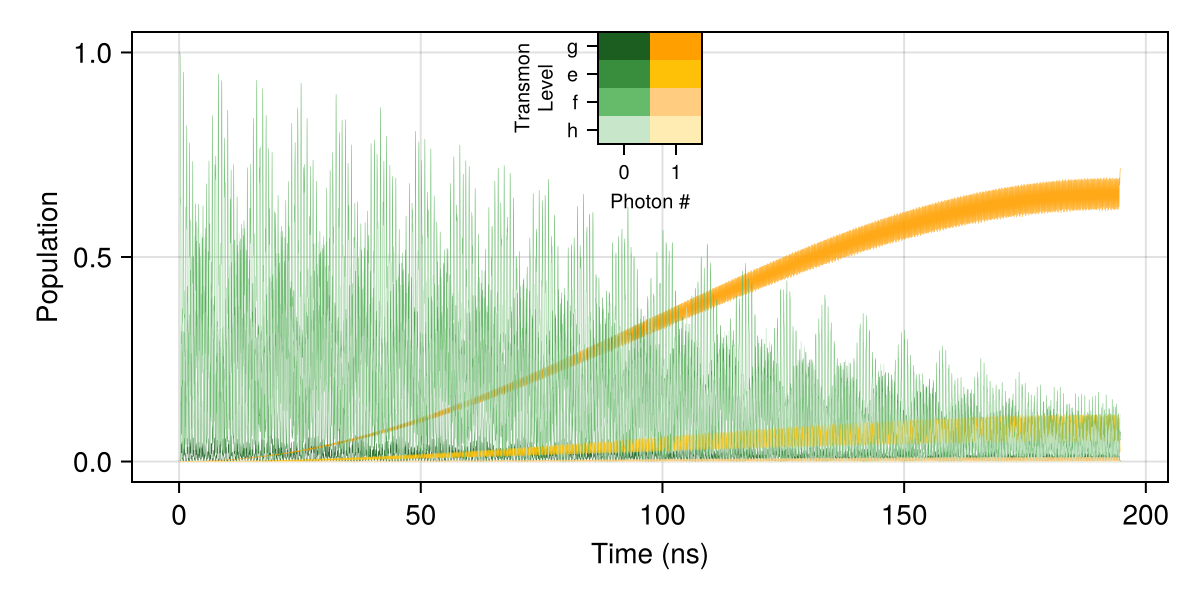

CairoMakie.Screen{IMAGE}


[2024-12-26 13:37:02] Error: Error watching manifest exception = MethodError: no method matching (::Lz4_jll.var"#make_wrapper_dict#12"{Lz4_jll.var"#parse_wrapper_platform#11"})(::String, ::Vector{String})
The function `make_wrapper_dict` exists, but no method is defined for this combination of argument types.
Stacktrace:
 [1] top-level scope
   @ ~/.julia/packages/JLLWrappers/jXOYx/src/toplevel_generators.jl:160
Revise evaluation error at /Users/gavinrockwood/.julia/packages/JLLWrappers/jXOYx/src/toplevel_generators.jl:160

Stacktrace:
 [1] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::@Kwargs{})
   @ Revise ~/.julia/packages/Revise/vhmOR/src/lowered.jl:284


In [102]:
run_res = Dict{String, Any}("states" => run_res_no_ramp.states, "times" => run_res_no_ramp.times)
EVs = EVs_no_ramp

figsize = (600, 300)
fig = cm.Figure(size = figsize, px_per_unit = 10)

tlevels = [0,1,2,3]
clevels = [0,1]

main_ax = cm.Axis(fig[1,1], xlabel = "Time (ns)", ylabel = "Population")

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color, linewidth = 0.25, alpha = 0.9)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    x = run_res["times"][1:52:end]
    y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    #cm.lines!(main_ax, x,y, color = color/1.5, linewidth = 1, alpha = 1)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
    
end
#cm.Legend(fig[1,2], main_ax, nbanks = 1)
#cm.axislegend(main_ax, position = :rc, nbanks = 2)



w_rel = 0.1
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.5,
                    valign = 1,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:bottom),
                    xticks = ([1,2], ["0", "1"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon\nLevel",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:2, end:-1:1]
cm.heatmap!(legend_ax, z)




#cm.save("figures/f0g1SidebandNoRamp.png", fig, px_per_unit = 10)
display(fig)

##### Plot with Floquet Projections and stroboscopic samplings

In [96]:
floq_tracking_no_ramp = SC.Dynamics.Get_Pulse_Floquet_Sweep(Mode3.hilbertspace, Mode3.Ô_drive, opt_res);

[2024-12-25 20:46:13] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


[2024-12-25 20:46:19] Info: Done With Floquet Sweep
[2024-12-25 20:46:19] Info: Tracking State


Progress:  18%|███████▍                                 |  ETA: 0:00:05

[2024-12-25 20:46:20] Info: Running the necessary time evolutions


In [97]:
floq_projections_no_ramp = SC.Dynamics.Pulse_Floquet_Projections(run_res_no_ramp.states[1:52:end], floq_tracking_no_ramp);


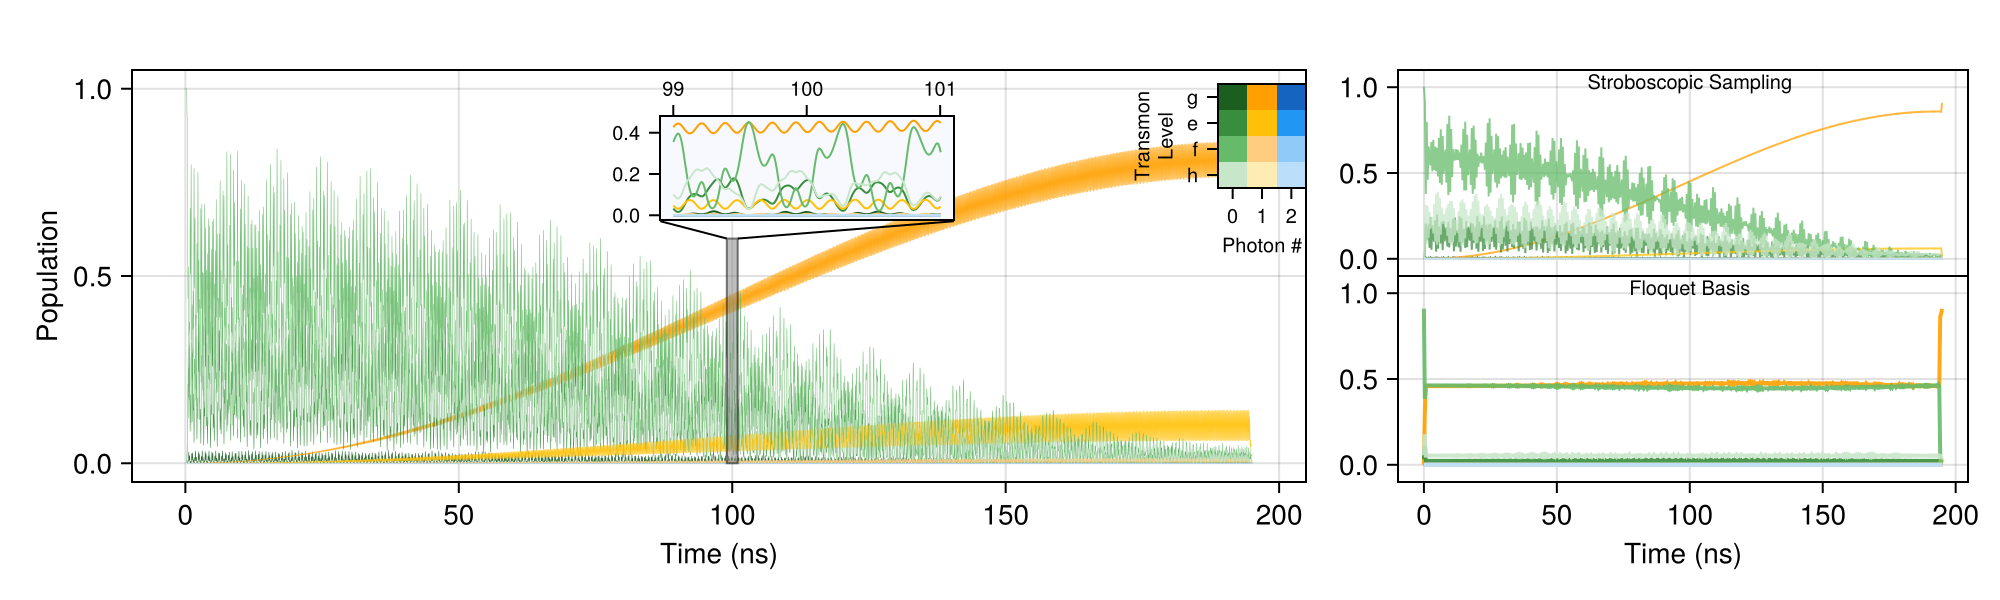

CairoMakie.Screen{IMAGE}


In [98]:
run_res = Dict{String, Any}("states" => run_res_no_ramp.states, "times" => run_res_no_ramp.times)
EVs = EVs_no_ramp

figsize = (1000, 300)
fig = cm.Figure(size = figsize, px_per_unit = 10)

ga = fig[1,1:2] = cm.GridLayout()
gb = fig[1,3] = cm.GridLayout()

gA = Axis(ga[1, 1], xlabel = "Time (ns)", ylabel = "Population")
gB1 = Axis(gb[1, 1], limits = ((nothing, nothing), (-0.1, 1.1)))
cm.hidexdecorations!(gB1, grid = false)
gB2 = Axis(gb[2, 1], limits = ((nothing, nothing), (-0.1, 1.1)), xlabel = "Time (ns)")
cm.rowgap!(gb, 0)

tlevels = [0,1,2,3]
clevels = [0,1,2]

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(gA, x,y, color = color, linewidth = 0.25, alpha = 0.9)
    
end




w_rel = 0.075
h_rel = 0.25
legend_ax = cm.Axis(ga[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 1,
                    valign = 0.95,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:bottom),
                    xticks = ([1,2,3], ["0", "1", "2"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon\nLevel",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:3, end:-1:1]
cm.heatmap!(legend_ax, z)


for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:52:end]
    y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(gB1, x,y, color = color, linewidth = 1, alpha = 0.75)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    
end


for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:52:end]
    y = real.(floq_projections_no_ramp[string((pair[2],pair[1]))])#[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(gB2, x,y, color = color, linewidth = 2, alpha = 0.9)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
end
cm.text!(gB2, 100,1.1, text = "Floquet Basis", align = (:center, :top), fontsize = 10)
cm.text!(gB1, 100,1.1, text = "Stroboscopic Sampling", align = (:center, :top), fontsize = 10)

w_rel = 0.25
h_rel = 0.25
inset_ax = cm.Axis(ga[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.6,
                    valign = 0.85,
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([99,100,101], ["99", "100", "101"]),
                    yticks = [0.0,0.2,0.4, 0.6])
                    
#cm.hidedecorations!(inset_ax)
cm.translate!(inset_ax.scene, 0, 0, 5)
cm.translate!(inset_ax.elements[:background], 0, 0, 5)

start_time = 99#99.5
stop_time = 101#100.5

start = findfirst(x -> x > start_time, run_res["times"])
stop = findfirst(x -> x > stop_time, run_res["times"])

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][start:stop]
    y = real.(EVs[(pair[2],pair[1])])[start:stop]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(inset_ax, x,y, color = color, linewidth = 1, alpha = 1, label = label)
end

cm.poly!(gA, Point2f[(start_time, 0), (stop_time, 0), (stop_time, 0.6), (start_time, 0.6)], color = (:grey, 0.5), strokecolor = (:black, 0.5), strokewidth = 1)

x0 = start_time
y0 = 0.6

xf = w_rel*run_res["times"][end]*1.78
yf = (0.5*h_rel/4+0.615)

cm.lines!(gA, [x0, xf], [y0, yf], color = :black, linewidth = 1)

x0 = stop_time
y0 = 0.6
xf = run_res["times"][end] - (w_rel*run_res["times"][end]*1.12)
yf = (0.5*h_rel/4+0.615)

cm.lines!(gA, [x0, xf], [y0, yf], color = :black, linewidth = 1)
cm.save("figures/f0g1SidebandSmallRampV2.png", fig, px_per_unit = 10)
display(fig)

### $\ket{0}+\ket{4}$

#### Getting Data

In [47]:
Mode3.Stuff["Drive_Sequences"]["Prep_0_+_4"]

14-element Vector{Any}:
 "q_ge_0"
 "q_half_ef0"
 "sb_f0g1"
 "q_ge_1/2"
 "q_ef_1/2"
 "q_ge_1/2"
 "sb_f1g2"
 "q_ge_1"
 "q_ef_1"
 "q_ge_1"
 "sb_f2g3"
 "q_ge_0"
 "q_ef_0"
 "sb_f3g4"

In [48]:
ψ = Mode3.dressed_states[(0,0)]

prep_0p4_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, Mode3.Stuff["Drive_Sequences"]["Prep_0_+_4"], spns = "Stroboscopic")

The Name for this run is: Operator_Sequence_Wed-Dec-25-24.20.5
It is being saved at: Data/
[2024-12-25 20:05:19] Info: Running operator q_ge_0
[2024-12-25 20:05:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-12-25 20:05:21] Info: Time Evolution Complete
[2024-12-25 20:05:21] Info: Saving Steps
[2024-12-25 20:05:22] Info: Done with Step_1
[2024-12-25 20:05:22] Info: Running operator q_half_ef0
[2024-12-25 20:05:22] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-12-25 20:05:24] Info: Time Evolution Complete
[2024-12-25 20:05:24] Info: Saving Steps
[2024-12-25 20:05:25] Info: Done with Step_2
[2024-12-25 20:05:25] Info: Running operator sb_f0g1
[2024-12-25 20:05:25] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-12-25 20:05:32] Info: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.2172, 0.4344, 0.6516, 0.8688, 1.086, 1.3032, 1.5204, 1.7376…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [49]:
EVs_prep_0p4 = SC.Utils.Get_EVs(prep_0p4_res["states"], SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

#### Plotting

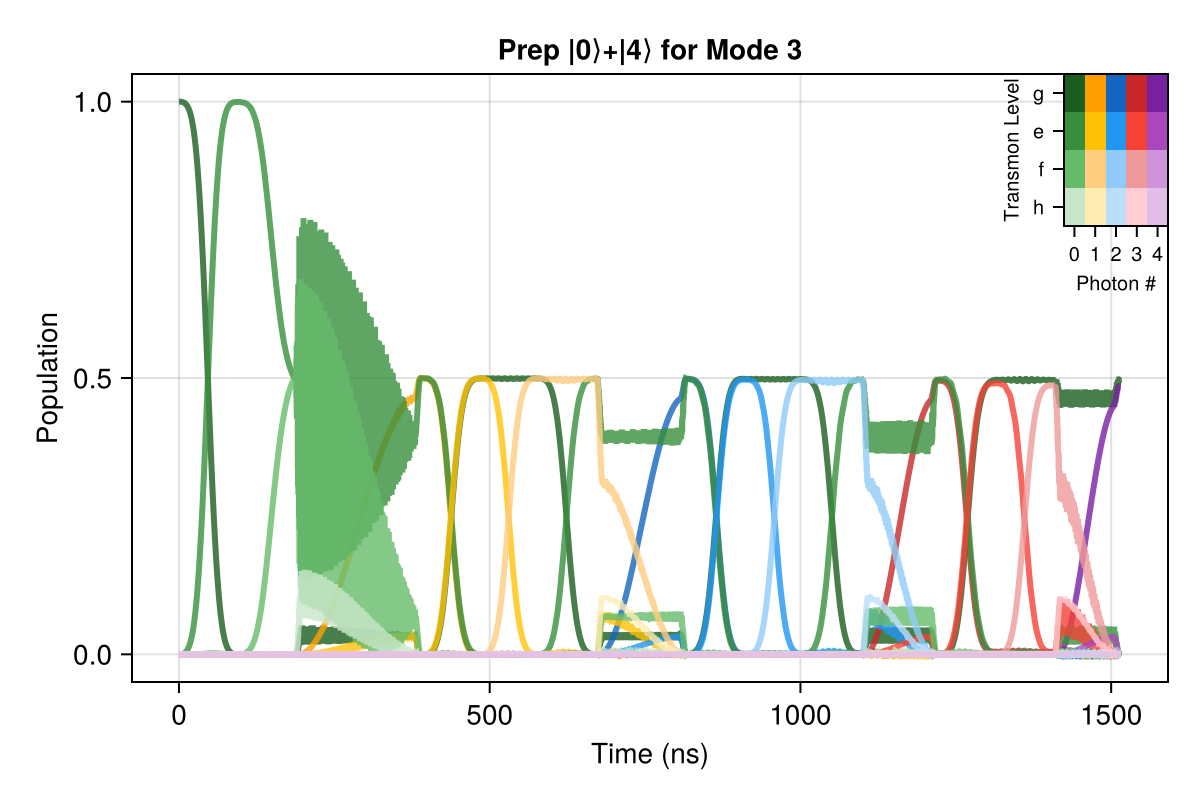

CairoMakie.Screen{IMAGE}


In [50]:
run_res = prep_0p4_res
EVs = EVs_prep_0p4

figsize = (600, 400)
fig = cm.Figure(size = figsize, px_per_unit = 10)

markers = ['∘' , '□', '▿', '▵', '⊲', '⊳'] 
markersizes = [20, 10, 20, 20, 20, 20]

tlevels = [0,1,2,3]
clevels = [0,1,2,3,4]

main_ax = cm.Axis(fig[1,1], title = "Prep |0⟩+|4⟩ for Mode 3", xlabel = "Time (ns)", ylabel = "Population")

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    cm.lines!(main_ax, x,y, color = color, linewidth = 3, alpha = 0.8)

    #x = run_res["times"][1:30:end]
    #y = real.(EVs[(pair[2],pair[1])])[1:30:end]
    #cm.lines!(main_ax, x,y, color = color, linewidth = 3, alpha = 0.8)
    #cm.scatterlines!(main_ax, x,y, color = color, linewidth = 0, alpha = 0.8, markersize = markersizes[pair[2]+1], marker = markers[pair[2]+1])
end


w_rel = 0.1
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 1,
                    valign = 1,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:bottom),
                    xticks = ([1,2,3,4,5], ["0", "1", "2", "3", "4"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[:, end:-1:1]
cm.heatmap!(legend_ax, z)




cm.save("figures/mode3_prep_0_p_4_no_loss.png", fig, px_per_unit = 10)
display(fig)

### $2\pi$ and $4\pi$ Sidebands

#### Getting Data

In [6]:
Mode3.Stuff["op_drive_params"]

ψ = Mode3.dressed_states[(2,1)] + Mode3.dressed_states[(2,3)]
ψ = ψ/norm(ψ)

sb_f1g2_2pi_f3g4_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_f1g2_2pi_f3g4"], spns = "Stroboscopic")

ψ = Mode3.dressed_states[(2,0)] + Mode3.dressed_states[(2,3)]
ψ = ψ/norm(ψ)

sb_f0g1_4pi_f3g4_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_f0g1_4pi_f3g4"], spns = "Stroboscopic")

The Name for this run is: Operator_Sequence_Tue-Jan-7-25.15.31
It is being saved at: Data/
[2025-01-07 15:31:35] Info: Running operator sb_f1g2_2pi_f3g4
[2025-01-07 15:31:35] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 42s (ETA: 0h 00m 00s)
[2025-01-07 15:32:18] Info: Time Evolution Complete
[2025-01-07 15:32:18] Info: Saving Steps
[2025-01-07 15:32:22] Info: Done with Step_1
[2025-01-07 15:32:22] Info: Done With Running Sequence
[2025-01-07 15:32:22] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


The Name for this run is: Operator_Sequence_Tue-Jan-7-25.15.32
It is being saved at: Data/
[2025-01-07 15:32:24] Info: Running operator sb_f0g1_4pi_f3g4
[2025-01-07 15:32:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 51s (ETA: 0h 00m 00s)
[2025-01-07 15:33:16] Info: Time Evolution Complete
[2025-01-07 15:33:16] Info: Saving Steps
[2025-01-07 15:33:17] Info: Done with Step_1
[2025-01-07 15:33:17] Info: Done With Running Sequence
[2025-01-07 15:33:17] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.3485, 0.697, 1.0455, 1.3941, 1.7426, 2.0911, 2.4396, 2.7881…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [7]:
EVs_f1g2_2pi_f3g4 = SC.Utils.Get_EVs(sb_f1g2_2pi_f3g4_res["states"], SC.Utils.Get_Projection_Ops(Mode3.dressed_states));
EVs_f0g1_4pi_f3g4 = SC.Utils.Get_EVs(sb_f0g1_4pi_f3g4_res["states"], SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

#### Plotting

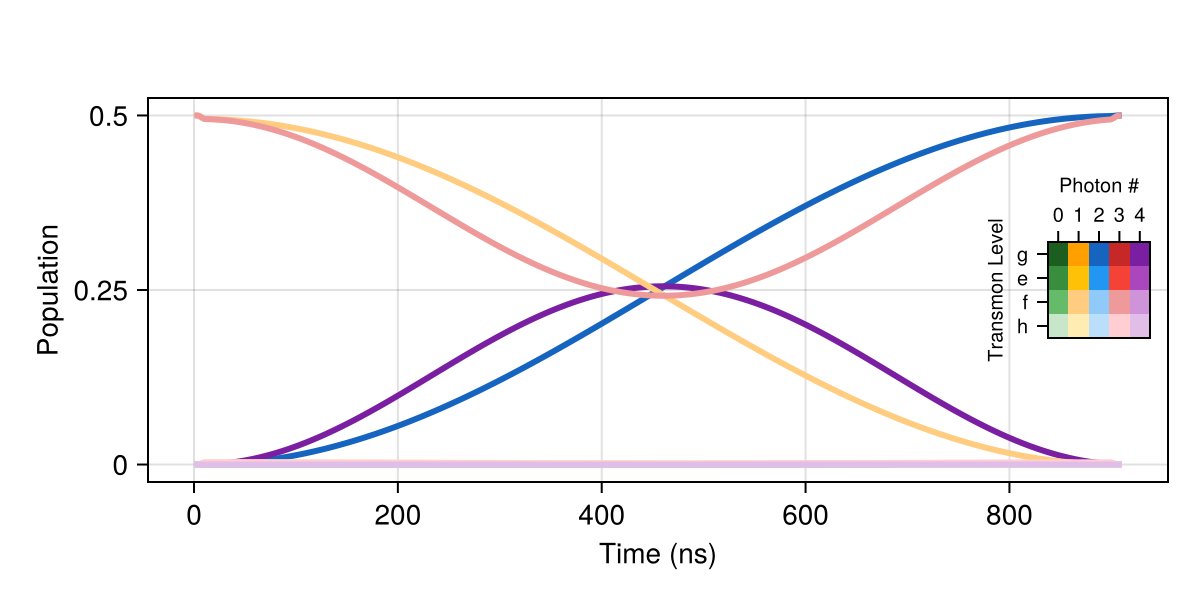

CairoMakie.Screen{IMAGE}


In [8]:
run_res = sb_f1g2_2pi_f3g4_res
EVs = EVs_f1g2_2pi_f3g4

figsize = (600, 300)
fig = cm.Figure(size = figsize, px_per_unit = 10)

tlevels = [0,1,2,3]
clevels = [0,1,2,3,4]

main_ax = cm.Axis(fig[1,1], xlabel = "Time (ns)", ylabel = "Population", yticks = ([0,0.25,0.5,0.75,1.0], ["0", "0.25", "0.5", "0.75", "1.0"]))

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color, linewidth = 3, alpha = 1)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    # x = run_res["times"][1:52:end]
    # y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    # #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    # cm.lines!(main_ax, x,y, color = color/1.5, linewidth = 1, alpha = 1)
    # #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
    
end
#cm.Legend(fig[1,2], main_ax, nbanks = 1)
#cm.axislegend(main_ax, position = :rc, nbanks = 2)



w_rel = 0.1
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.98,
                    valign = 0.5,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([1,2,3,4,5], ["0", "1", "2", "3", "4"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:5, end:-1:1]
cm.heatmap!(legend_ax, z)




cm.save("figures/sb_f1g2_2pi_f3g4_res.png", fig, px_per_unit = 10)
display(fig)

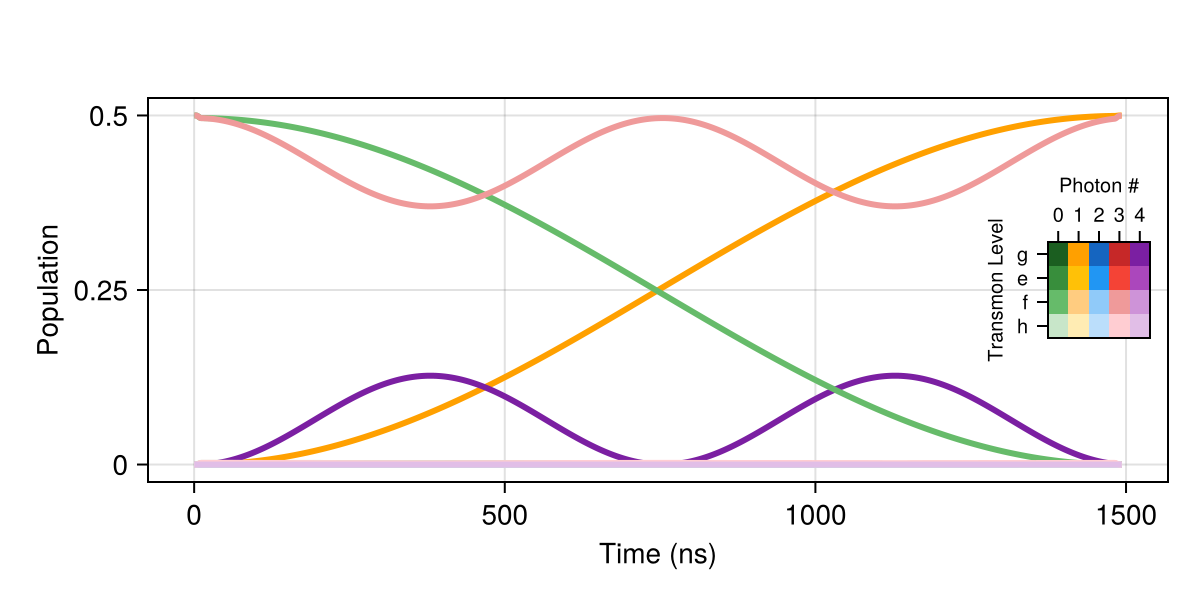

CairoMakie.Screen{IMAGE}


In [9]:
run_res = sb_f0g1_4pi_f3g4_res
EVs = EVs_f0g1_4pi_f3g4

figsize = (600, 300)
fig = cm.Figure(size = figsize, px_per_unit = 10)

tlevels = [0,1,2,3]
clevels = [0,1,2,3,4]

main_ax = cm.Axis(fig[1,1], xlabel = "Time (ns)", ylabel = "Population", yticks = ([0,0.25,0.5,0.75,1.0], ["0", "0.25", "0.5", "0.75", "1.0"]))

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color, linewidth = 3, alpha = 1)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    # x = run_res["times"][1:52:end]
    # y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    # #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    # cm.lines!(main_ax, x,y, color = color/1.5, linewidth = 1, alpha = 1)
    # #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
    
end
#cm.Legend(fig[1,2], main_ax, nbanks = 1)
#cm.axislegend(main_ax, position = :rc, nbanks = 2)



w_rel = 0.1
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.98,
                    valign = 0.5,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([1,2,3,4,5], ["0", "1", "2", "3", "4"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:5, end:-1:1]
cm.heatmap!(legend_ax, z)




cm.save("figures/sb_f0g1_4pi_f3g4_res.png", fig, px_per_unit = 10)
display(fig)

# Floquet Plot

In [302]:
floq_mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

## Getting Data

[2024-12-20 12:09:17] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


[2024-12-20 12:09:31] Info: Done With Floquet Sweep
[2024-12-20 12:09:31] Info: Fit Stuff: 3-element Vector{Float64}:	 0.03766466356023802	 0.0024389735332232152	 2.127683942419102


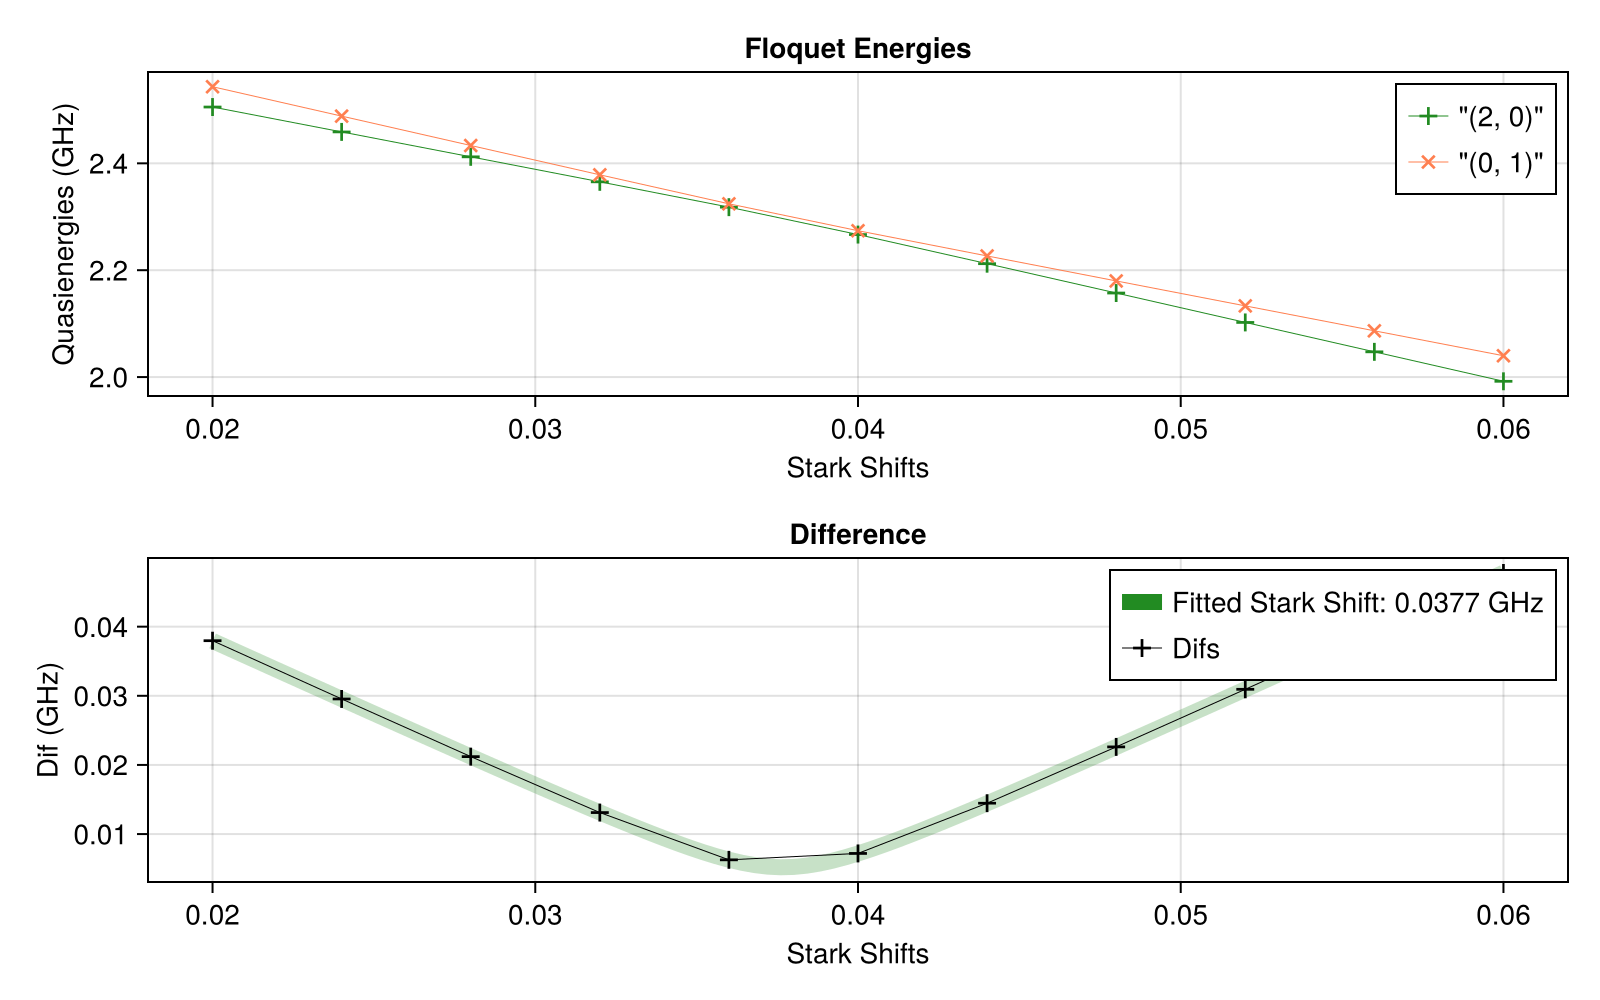

Stark shift res: Any[0.03766466356023802, 192.70181114271873, Dict{Any, Any}("bottom" => Dict{Any, Any}("x" => [0.020000000000000018, 0.02400000000000002, 0.028000000000000025, 0.03200000000000003, 0.03600000000000003, 0.040000000000000036, 0.04400000000000004, 0.04800000000000004, 0.052000000000000046, 0.05600000000000005, 0.06000000000000005], "fit_y" => [0.03794137948555385, 0.03709848659170329, 0.03625597592107535, 0.035413874753424356, 0.034572213012471216, 0.033731023592161645, 0.032890342732131456, 0.032050210451196784, 0.031210671049526635, 0.030371773692432616, 0.029533573091546996, 0.028696130302707724, 0.02785951366433085, 0.02702379990569273, 0.026189075461719252, 0.02535543804005675, 0.02452299849801231, 0.023691883102250337, 0.02286223626408191, 0.022034223869370418, 0.02120803735670017, 0.020383898743559132, 0.019562066862143634, 0.018742845150006165, 0.01792659145465379, 0.017113730467488607, 0.01630476961850287, 0.01550031956373435, 0.014701120818160175, 0.013908078677

In [306]:
fngnp1_ε = 0.735
drive_op = Mode3.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.02, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(floq_mode3, state1, state2, fngnp1_ε, stark_shift_list, return_fig_data=true)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

## Making Paper Plot

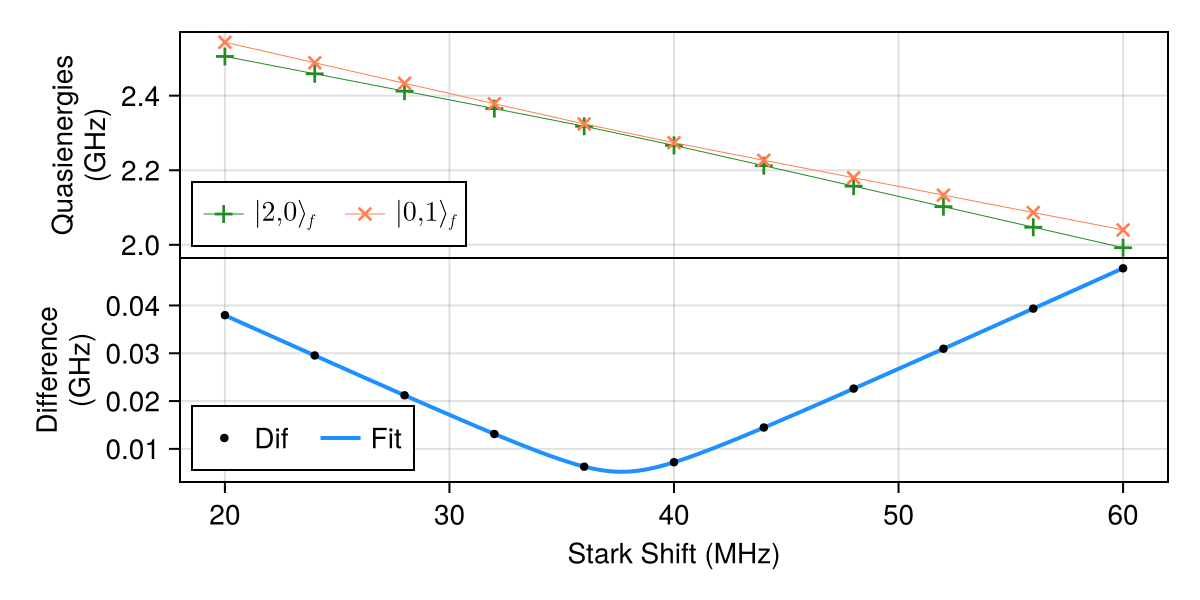

CairoMakie.Screen{IMAGE}


In [ ]:
fig = cm.Figure(size=(600, 300))
ax1 = cm.Axis(fig[1,1], ylabel = "Quasienergies\n(GHz)")
hidexdecorations!(ax1, grid = false)
ax2 = cm.Axis(fig[2,1], ylabel = "Difference\n(GHz)", xlabel = "Stark Shift (MHz)")

x = stark_shift_res[3]["top"]["x"].*1000
y = stark_shift_res[3]["top"]["\"(2, 0)\""]
cm.scatterlines!(ax1, x,y, color = "forestgreen", marker = '+', markersize = 20, linewidth = 0.5, label=L"$|2,0\rangle_{f}$")

x = stark_shift_res[3]["top"]["x"].*1000
y = stark_shift_res[3]["top"]["\"(0, 1)\""]
cm.scatterlines!(ax1, x,y, color = "coral", marker = '×', markersize = 20, linewidth = 0.5, label=L"$|0,1\rangle_{f}$")


x = stark_shift_res[3]["bottom"]["fit_x"].*1000
y = stark_shift_res[3]["bottom"]["fit_y"]
ax2_1 = cm.lines!(ax2, x, y, color = "dodgerblue" , linewidth = 2, alpha = 1, label = "Fit")


x = stark_shift_res[3]["bottom"]["x"].*1000
y = stark_shift_res[3]["bottom"]["y"]
ax2_2 = cm.scatterlines!(ax2, x, y, color = "black", marker =:circle , linewidth = 0, markersize = 6, label = "Dif")

cm.axislegend(ax1, position=:lb, nbanks = 2)
cm.axislegend(ax2, [ax2_2, ax2_1], ["Dif", "Fit"], position = :lb, nbanks = 2)

cm.rowgap!(fig.layout, 0)

#cm.save("figures/FloquetStarkshiftFitting.png", fig, px_per_unit = 10)
display(fig)

In [437]:
println(stark_shift_res[1]*1000)
println(stark_shift_res[2])

37.66466356023802
192.70181114271873


In [346]:
stark_shift_res[3]["bottom"]

Dict{Any, Any} with 4 entries:
  "x"     => [0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.05…
  "fit_y" => [0.0379414, 0.0370985, 0.036256, 0.0354139, 0.0345722, 0.033731, 0…
  "fit_x" => [0.02, 0.0204, 0.0208, 0.0212, 0.0216, 0.022, 0.0224, 0.0228, 0.02…
  "y"     => Any[0.0379703, 0.0295427, 0.0212019, 0.0131058, 0.00626628, 0.0071…